In [ ]:
# PROJ518 - Cotton Disease Identification
# Goel Biju (10576090)

# Transfer Learning

# TensorFlow version 2
# %tensorflow_version 2.x

import tensorflow as tf
print("TensorFlow version: " + tf.__version__)

# Find GPU device
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model, Sequential

from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.resnet152V2 import ResNet152V2
# Xception...

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np

import cv2
from matplotlib import pyplot as plt

import os
import shutil

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version: 2.8.2
Found GPU at: /device:GPU:0


In [ ]:
# Data source
from google.colab import drive

# Importing the dataset (stored in Google Drive)
drive.mount("/content/drive", force_remount=True)

# !ls "/content/drive/MyDrive/Cotton Dataset/data"
data_dir = "/content/drive/MyDrive/PROJ518/Cotton Dataset/data"

Mounted at /content/drive


In [ ]:
# Additional parameters
IMAGE_SIZE = [256, 256]

# importing the dataset
train_path = '/content/drive/My Drive/PROJ518/Cotton Dataset/data/train'
valid_path = '/content/drive/My Drive/PROJ518/Cotton Dataset/data/test'

In [ ]:
# Inception model
inceptionv3 = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=IMAGE_SIZE + [3]
)

In [ ]:
for layer in inceptionv3.layers:
  layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('/content/drive/My Drive/PROJ518/Cotton Dataset/data/train/*')
folders

['/content/drive/My Drive/PROJ518/Cotton Dataset/data/train/healthy',
 '/content/drive/My Drive/PROJ518/Cotton Dataset/data/train/leaf_curl']

In [ ]:
# Clear any previous models created to prevent
# adding unnecessary layers when testing again
tf.keras.backend.clear_session()

# our layers - you can add more if you want
x = Flatten()(inceptionv3.output)

prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=inceptionv3.input, outputs=prediction)

# Model structure
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                             

In [ ]:
# Assigning cost function and optimizer  to the Model
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (256, 256), 
                                                 batch_size = 32,
                                                 class_mode = 'binary')

# TODO: Add augmentation to diseased leaves...
# 500 to 500 images of both classes


Found 226 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 16 images belonging to 2 classes.


In [ ]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
8/8 [==============================] - 73s 7s/step - loss: 0.8066 - accuracy: 0.7699 - val_loss: 0.8221 - val_accuracy: 0.8750
Epoch 2/20
8/8 [==============================] - 24s 3s/step - loss: 0.2535 - accuracy: 0.9292 - val_loss: 2.5597 - val_accuracy: 0.7500
Epoch 3/20
8/8 [==============================] - 24s 3s/step - loss: 0.1298 - accuracy: 0.9558 - val_loss: 1.8035 - val_accuracy: 0.8125
Epoch 4/20
8/8 [==============================] - 25s 3s/step - loss: 0.1094 - accuracy: 0.9690 - val_loss: 2.6667 - val_accuracy: 0.8125
Epoch 5/20
8/8 [==============================] - 26s 4s/step - loss: 0.1138 - accuracy: 0.9823 - val_loss: 2.0868 - val_accuracy: 0.8125
Epoch 6/20
8/8 [==============================] - 24s 3s/step - loss: 0.1216 - accuracy: 0.9690 - val_loss: 1.8800 - val_accuracy: 0.8125
Epoch 7/20
8/8 [==============================] - 25s 3s/step - loss: 0.0708 - accuracy: 0.9867 - val_loss: 1.9027 - val_accuracy: 0.7500
Epoch 8/20
8/8 [==================

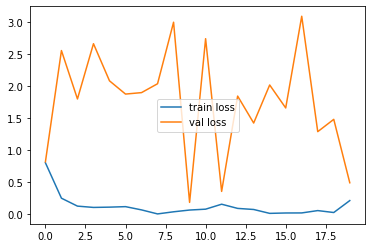

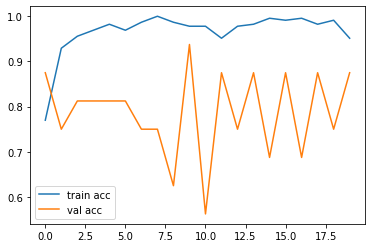

<Figure size 432x288 with 0 Axes>

In [ ]:

# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# # save it as a h5 file
# from tensorflow.keras.models import load_model
# model.save('inceptionv3.h5')

# Save the model

# Model save variables
save_dir = "/content/drive/MyDrive/PROJ518/models/transfer-learning/"
# model_name = 'proj518_baseline_{0}-e{1}-bs{2}-da-{3}.h5'.format(baseline_num, 
#                                                                 epochs, 
#                                                                 batch_size if batch_size else "NA", 
#                                                                 str(data_augmentation).lower())

model_name = 'proj518_tl_inceptionv3_e20-bs32-da-F.h5'

print("Saving as: ", save_dir + model_name)

model.save(os.path.join(save_dir, model_name))
# shutil.copy('models/baseline-1.h5', data_dir)

Saving as:  /content/drive/MyDrive/PROJ518/models/transfer-learning/proj518_tl_inceptionv3_e20-bs32-da-F.h5


In [ ]:
# y_pred = model.predict(test_set)
# y_pred

In [ ]:
# import numpy as np
# y_pred = np.argmax(y_pred, axis=1)
# y_pred